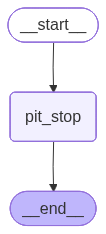

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Literal

class RaceState(TypedDict):
    current_tyre_compound: Literal["Soft", "Medium", "Hard"]

def pit_stop(state):
    print("---Pit Stop---")
    return {"current_tyre_compound": "Hard"}

builder = StateGraph(RaceState)
builder.add_node("pit_stop", pit_stop)

builder.add_edge(START, "pit_stop")
builder.add_edge("pit_stop", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
graph.invoke({"current_tyre_compound" : "Medium"})

---Pit Stop---


{'current_tyre_compound': 'Hard'}

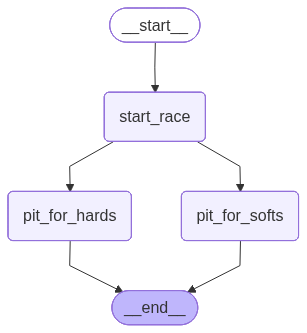

In [3]:
def node_start_race(state):
    print("---Race Start---")
    return {}

def pit_for_softs(state):
    print("---Pitting for Softs---")
    return {"current_tyre_compound": "Soft"}

def pit_for_hards(state):
    print("---Pitting for Hards---")
    return {"current_tyre_compound": "Hard"}

builder = StateGraph(RaceState)
builder.add_node("start_race", node_start_race)
builder.add_node("pit_for_softs", pit_for_softs)
builder.add_node("pit_for_hards", pit_for_hards)

builder.add_edge(START, "start_race")
builder.add_edge("start_race", "pit_for_softs")
builder.add_edge("start_race", "pit_for_hards")
builder.add_edge("pit_for_softs", END)
builder.add_edge("pit_for_hards", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"current_tyre_compound" : "Medium"})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Race Start---
---Pitting for Hards---
---Pitting for Softs---
InvalidUpdateError occurred: At key 'current_tyre_compound': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


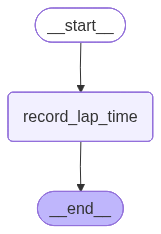

In [5]:
from operator import add
from typing import Annotated, List

class LapDataState(TypedDict):
    lap_times: Annotated[List[float], add]

def record_lap_time(state):
    print("---Recording Lap Time---")
    new_lap_time = state['lap_times'][-1] - 0.1
    return {"lap_times": [round(new_lap_time, 3)]}

builder = StateGraph(LapDataState)
builder.add_node("record_lap_time", record_lap_time)

builder.add_edge(START, "record_lap_time")
builder.add_edge("record_lap_time", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"lap_times" : [90.521]})

---Recording Lap Time---


{'lap_times': [90.521, 90.421]}

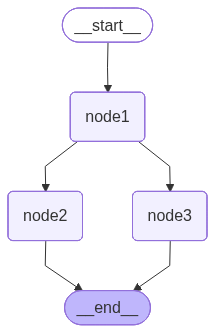

In [7]:
def record_lap_time_node1(state):
    print("---Recording Lap Time (Node 1)---")
    return {"lap_times": [89.123]}

def record_lap_time_node2(state):
    print("---Recording Lap Time (Node 2)---")
    return {"lap_times": [88.950]}

def record_lap_time_node3(state):
    print("---Recording Lap Time (Node 3)---")
    return {"lap_times": [88.755]}

builder = StateGraph(LapDataState)
builder.add_node("node1", record_lap_time_node1)
builder.add_node("node2", record_lap_time_node2)
builder.add_node("node3", record_lap_time_node3)

builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node1", "node3")
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"lap_times" : []})

---Recording Lap Time (Node 1)---
---Recording Lap Time (Node 2)---
---Recording Lap Time (Node 3)---


{'lap_times': [89.123, 88.95, 88.755]}

In [9]:
try:
    graph.invoke({"lap_times" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


In [10]:
def reduce_lap_times_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultLapState(TypedDict):
    lap_times: Annotated[List[float], add]

class CustomReducerLapState(TypedDict):
    lap_times: Annotated[List[float], reduce_lap_times_list]

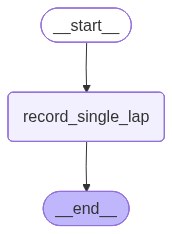

Invoking default graph with None:
TypeError occurred: can only concatenate list (not "NoneType") to list


In [11]:
def record_single_lap_time(state):
    print("---Recording Single Lap Time---")
    return {"lap_times": [87.500]}

builder_default = StateGraph(DefaultLapState)
builder_default.add_node("record_single_lap", record_single_lap_time)
builder_default.add_edge(START, "record_single_lap")
builder_default.add_edge("record_single_lap", END)
graph_default = builder_default.compile()

display(Image(graph_default.get_graph().draw_mermaid_png()))

try:
    print("Invoking default graph with None:")
    print(graph_default.invoke({"lap_times" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

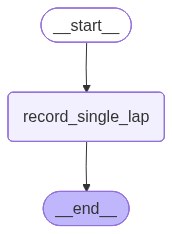


Invoking custom graph with None:
---Recording Single Lap Time---
{'lap_times': [87.5]}


In [12]:
builder_custom = StateGraph(CustomReducerLapState)
builder_custom.add_node("record_single_lap", record_single_lap_time)
builder_custom.add_edge(START, "record_single_lap")
builder_custom.add_edge("record_single_lap", END)
graph_custom = builder_custom.compile()

display(Image(graph_custom.get_graph().draw_mermaid_png()))

try:
    print("\nInvoking custom graph with None:")
    print(graph_custom.invoke({"lap_times" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

In [13]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class CustomRadioState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    fuel_level: float
    tyre_life_percent: int

class ExtendedRadioState(MessagesState):
    fuel_level: float
    tyre_life_percent: int

In [14]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

initial_messages = [AIMessage(content="Box this lap for hards.", name="RaceEngineer"),
                    HumanMessage(content="Copy.", name="Driver")
                   ]

new_message = AIMessage(content="Stay out, stay out.", name="RaceEngineer")

add_messages(initial_messages , new_message)

[AIMessage(content='Box this lap for hards.', additional_kwargs={}, response_metadata={}, name='RaceEngineer', id='bdcee71f-9baa-48c1-81ca-7b53883cab14'),
 HumanMessage(content='Copy.', additional_kwargs={}, response_metadata={}, name='Driver', id='edfc3a78-7dc0-4f8e-9789-367a3ec72ed3'),
 AIMessage(content='Stay out, stay out.', additional_kwargs={}, response_metadata={}, name='RaceEngineer', id='f5d8f989-37ea-4396-92eb-07cfbe519c69')]

In [15]:
initial_messages = [AIMessage(content="What's the gap to P2?", name="Driver", id="msg1"),
                    AIMessage(content="Gap is 2.5 seconds.", name="RaceEngineer", id="msg2")
                   ]

new_message = AIMessage(content="Gap holding at 2.5.", name="RaceEngineer", id="msg2")

add_messages(initial_messages , new_message)

[AIMessage(content="What's the gap to P2?", additional_kwargs={}, response_metadata={}, name='Driver', id='msg1'),
 AIMessage(content='Gap holding at 2.5.', additional_kwargs={}, response_metadata={}, name='RaceEngineer', id='msg2')]

In [16]:
from langchain_core.messages import RemoveMessage

messages = [AIMessage("Keep pushing.", name="Engineer", id="lap10_eng")]
messages.append(HumanMessage("Tyres are starting to go.", name="Driver", id="lap11_drv"))
messages.append(AIMessage("Box next lap then.", name="Engineer", id="lap11_eng"))
messages.append(HumanMessage("Understood.", name="Driver", id="lap11_drv_ack"))

delete_message_ids = [m.id for m in messages[:-2]]
delete_messages = [RemoveMessage(id=msg_id) for msg_id in delete_message_ids]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='lap10_eng'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='lap11_drv')]


In [17]:
add_messages(messages , delete_messages)

[AIMessage(content='Box next lap then.', additional_kwargs={}, response_metadata={}, name='Engineer', id='lap11_eng'),
 HumanMessage(content='Understood.', additional_kwargs={}, response_metadata={}, name='Driver', id='lap11_drv_ack')]